### Copy this notebook to your data directory. The sys.path command below will add the Useful Code directory to allow importing code from there.

## Contents:

- [Hamamatsu](#Hamamatsu)
- [Andor](#Andor)
- [SNR](#SNR)
- [Fitting](#Fitting)
- [Loading](#Loading)
- [FORT_Lifetime](#FORT_Lifetime)
- [Decay](#Decay)
- [Counter](#Counter)
- [Retention](#Retention)
- [Beam](#Beam)
- [Metadata](#Metadata)
- [Copy](#Copy)

In [3]:
%matplotlib notebook

import h5py
from numpy import *
import pandas as pd
import os
import sys
import glob
if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python2"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python2"
    if not os.path.isdir(repo_path):  # Checks if lab computer or personal machine
        repo_path = r"C:\Users\Juan\Repos\Hybrid_H5\H5_python2"
sys.path.append(repo_path)
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.special import factorial, gamma, gammaincc
import counterh5 as ch5
import seaborn as sbs
import PoissonCuts
import itertools
sbs.reset_orig()
import imageh5 as i5
from imageh5 import seedpermute
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
# Initialization
h5filename = glob.glob('./'+'*.hdf5')[0]
print h5filename
h5file = h5py.File(h5filename)

shots = 2
measurements = h5file['settings/experiment/measurementsPerIteration'][()]
iterations = len(h5file['/iterations/'].items())

iVars = []
if iterations > 1:
    for i in h5file['settings/experiment/independentVariables/'].iteritems(): 
        tmp=eval(i[1]['function'][()])
        if (type(tmp) == list) | (type(tmp) == ndarray) | (type(tmp) == tuple): 
            print i
            iVars.append((i[0],i[1]['function'][()],i[1]['description'][()]))
    iVarVals = list(itertools.product(*[eval(iVars[i][1]) for i in range(len(iVars))]))

    ivs = array(list(itertools.product(*[eval(iVars[i][1]) for i in range(len(iVars))])))
    print ivs
    #ivs = array(iVarVals[:])[:,0]
else :
    ivs = array([0])

if  shots == 2:
    Readout_shot = 0
    Background_shot = 1 
else:
    LAC_shot = 0
    Readout_shot = 1
    Background_shot = 2 


## Hamamatsu

In [ ]:
roi = array([range(5,8),range(3,6)])#3X3
#roi = array([range(3,6),range(4,7)])#3X3
#roi = array([range(0,9),range(0,9)])#3X3
#printroi
HDat = zeros((iterations,measurements,shots,len(roi[0,:]),len(roi[1,:])),dtype=int)
Herarr = zeros((iterations,measurements,shots),dtype=int)
for it in range(iterations):
    good_measurements = h5file[( '/experiments/0/iterations/{}/measurements'.format(it) )].keys()
    for ind,ms in enumerate(good_measurements):
        if ind >= measurements:
            continue
        for sht in range(shots):
            filepath='/experiments/0/iterations/{}/measurements/{}/data/Hamamatsu/shots/{}'.format(it,ms,sht)
            #print filepath
            try:
                mesDat = array(h5file[(filepath)])
                #fig,ax = plt.subplots(1,1)
                #ax.imshow(mesDat)
                #print mesDat[roi[0],:][:,roi[1]]
                HDat[it,ind,sht,:,:] = mesDat[roi[0],:][:,roi[1]]
                #print ("mesDatarr",mesDatarr[it,ms,sht,:,:])
            except KeyError as e:
                print e
                print filepath
                Herarr[it,ind,sht] = 1
                HDat = -1*ones((len(roi[0,:]),len(roi[1,:])),dtype=int)


In [ ]:
HmCountDat = HDat[:,:,:,:,:].sum(3).sum(3)#+mesDatarr[:,:,:,0,1]#[2,3],[2,3]]
BGmu = HmCountDat[:,:,Background_shot].mean(1)
BGstd = HmCountDat[:,:,Background_shot].std(1)/sqrt(len(HmCountDat[0,:,Background_shot]))
FGmu = HmCountDat[:,:,Readout_shot].mean(1)
FGstd = HmCountDat[:,:,Readout_shot].std(1)/sqrt(len(HmCountDat[0,:,Readout_shot]))

In [ ]:
HmCountDat = HDat[:,:,:,:,:].sum(3).sum(3)#mesDatarr[:,:,:,1:3,0:2].sum(3).sum(3)+mesDatarr[:,:,:,1,2]#[2,3],[2,3]]
plots = False
HmBG = 20820
#print HmCountDat
for it in range(len(ivs)):
#for it in range(200,220):
    bns = linspace(min(HmCountDat[it,:,1])-100,max(HmCountDat[it,:,0])+100,30)
    if plots:
        fig,ax = plt.subplots(1,1)
        ax.hist(HmCountDat[it,:,0],histtype="step",bins=bns,label="Shot 1")
        ax.hist(HmCountDat[it,:,1],histtype="step",bins=bns,label="Shot 2")
        ax.legend()
        ax.set_title("{}".format(ivs[it]))
        fig.show()
        #fig.savefig("SingleAtoms01142020.png")
    SNR = (HmCountDat[it,:,0].mean(0)-HmCountDat[it,:,1].mean(0))/HmCountDat[it,:,1].mean(0)
    print SNR

In [ ]:
HmCountDat = HDat[:,:,:,:,:].sum(3).sum(3)#+mesDatarr[:,:,:,0,1]#[2,3],[2,3]]
BGmu = HmCountDat[:,:,Background_shot].mean(1)
BGstd = HmCountDat[:,:,Background_shot].std(1)/sqrt(len(HmCountDat[0,:,Background_shot]))
FGmu = HmCountDat[:,:,Readout_shot].mean(1)
FGstd = HmCountDat[:,:,Readout_shot].std(1)/sqrt(len(HmCountDat[0,:,Readout_shot]))
if iterations > 1:
    fig,ax = plt.subplots(1,1)
    ax.errorbar(ivs,FGmu,yerr=FGstd,Label= "Shot 0")
    ax.errorbar(ivs,BGmu,yerr=BGstd,label="Shot 1")
    ax.set_xlabel(iVars[0][0])
    ax.legend()
    fig.show()
else:
    print "Shot 1 : {:2.0f} +/- {:.0f}".format(FGmu[0],FGstd[0])
    print "Shot 2 : {:2.0f} +/- {:.0f}".format(BGmu[0],BGstd[0])
    print "Shots D : {:1.0f} +/- {:.0f}".format(FGmu[0]-BGmu[0],FGstd[0] + BGstd[0])
    SNRCountDat = HmCountDat
    SNR = 100*(SNRCountDat[:,:,0].mean(1)-SNRCountDat[:,:,1].mean(1))/SNRCountDat[:,:,1].mean(1)
    SNRD = 100*((SNRCountDat[:,:,0]-SNRCountDat[:,:,1])/SNRCountDat[:,:,1]).std(1)/sqrt(measurements)
    print "SNR : {:.1f} +/- {:.1f}".format(SNR[0],SNRD[0])

<IPython.core.display.Javascript object>


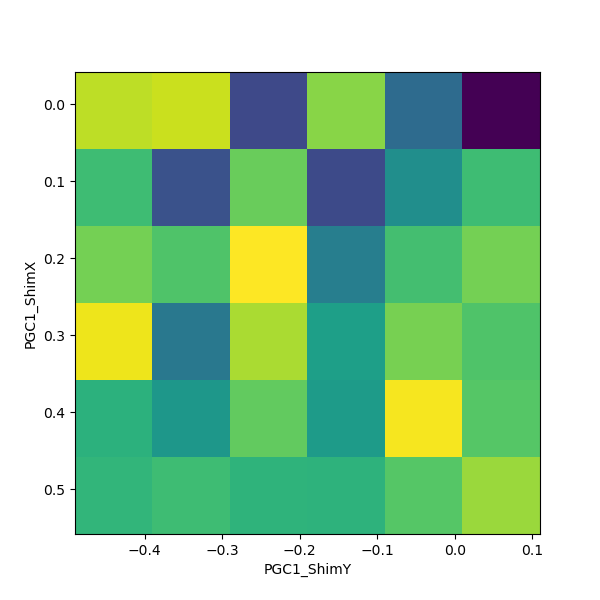

In [7]:
dat2d=array([[ivs[i,0],ivs[i,1],FGmu[i]] for i in range(len(ivs))])

list1=eval(iVars[0][1])
list2=eval(iVars[1][1])
plt.close('all')
fig,ax=plt.subplots(figsize=(6,6))
plt.ylabel(iVars[0][2])
plt.xlabel(iVars[1][2])
ax.imshow(dat2d[:,2].reshape((len(list2),len(list1))).T,interpolation='none', extent=[
        list2[0]-(list2[1]-list2[0])/2,
        list2[len(list2)-1]+(list2[1]-list2[0])/2,
        list1[len(list1)-1]+(list1[1]-list1[0])/2,
        list1[0]-(list1[1]-list1[0])/2
    ],aspect='auto')
          #,vmin=0,vmax=median(dat2d[:,2])*3.5)
plt.show()

In [ ]:
def dblGauss(x,x0,x1,std0,std1,a0,a1):
    xp0 = x-x0
    xp1 = x-x1
    g0 = a0*exp(-0.5*(xp0/std0)**2)
    g1 = a1*exp(-0.5*(xp1/std1)**2)
    return g0+g1

func = dblGauss
x0g = 21000.0
x1g = 23000.0
std0g = 200.0
std1g = 1000.0
a0g = 6.0e1
a1g = 6.0e1
guess = [x0g,x1g,std0g,std1g,a0g,a1g]

mulst = zeros((2,iterations))
dmulst = zeros((2,iterations))
for it in range(iterations):
    er = 0
    hdat = HmCountDat[it,:,0]
    bns = range(min(hdat),max(hdat),(max(hdat)-min(hdat))/30)
    h = histogram(hdat,bins=bns)#,normed=True)
    xdat = array(h[1][1:],dtype=float)
    ydat = array(h[0],dtype=float)

    #print xdat,xdat.shape
    #print ydat,ydat.shape
    #print guess

    try:
        popt,pcov = opt.curve_fit(f=func,xdata=xdat,ydata=ydat,p0=guess)
        perr = sqrt(diag(pcov))
    except RuntimeError as e:
        print e
        popt = None
        perr = None
        er = 1
    
    xlin = linspace(min(xdat),max(xdat),1000)
    fig,ax = plt.subplots(1,1)
    #ax.plot(xlin, func(xlin,*guess), label='guess')
    ax.hist(hdat, bins=bns, label='hist')
    if er:
        ax.set_title("iv = {}".format(ivs[it]))
    else:
        ax.plot(xlin, func(xlin,*popt), label='fit')
        ax.set_title("iv = {}\n".format(ivs[it])+"mu0 = {0[0]:0.0f} $\pm$ {1[0]:0.0f}, mu1 = {0[1]:0.0f} $\pm$ {1[1]:0.0f}".format(popt,perr))
        mulst[0,it] = popt[0]
        dmulst[0,it] = perr[0]
        mulst[1,it] = popt[1]
        dmulst[1,it] = perr[1]
        
    ax.legend()
    fig.show()

if iterations > 1:
    fig,ax = plt.subplots(1,1)
    df = mulst[1,:]-mulst[0,:]
    ddf = dmulst[1,:]+dmulst[0,:]
    ax.errorbar(ivs,df,yerr=ddf)
    ax.set_title("Difference\n mean = {:.0f} +/- {:.0f}".format(df.mean(),sqrt(df.std()**2+sum(ddf**2))))
    fig.show()
else:
    
    print "mu0 = {0[0]:.0f} +/- {1[0]:.0f} mu1 = {0[1]:.0f} +/- {1[1]:.0f}".format(mulst[:,0],dmulst[:,0])
    print "diff = {:.0f} +/- {:.0f}".format(mulst[1,0]-mulst[0,0],dmulst[1,0]+dmulst[0,0])
    SNR = (mulst[1,0]-mulst[0,0])/(mulst[0,0]-HmBG)
    dnom = (dmulst[1,0]+dmulst[0,0])/(mulst[1,0]-mulst[0,0])
    ddnom = dmulst[0,0]/(mulst[0,0]-HmBG)
    print "SNR = {:.1f} +/- {:.1f}".format((mulst[1,0]-mulst[0,0])/(mulst[0,0]-HmBG),SNR*(dnom+ddnom))

In [ ]:
print popt,perr

In [ ]:
folder =  os.path.split(os.getcwd())[-1]

aligning = True

mu0 = mulst[0,0]
dmu0 = dmulst[0,0]
mu1 = mulst[1,0]
dmu1 = dmulst[1,0]
df = mulst[1,0]-mulst[0,0]
ddf = dmulst[1,0]+dmulst[0,0]
SNR = SNR
dSNR = SNR*(dnom+ddnom)
columns = ['Motion','u0','du0','u1','du1','u1-u0','d(u1-u0)','SNR','dSNR']
wrtdat = pd.DataFrame([folder,mu0,dmu0,mu1,dmu1,df,ddf,SNR,dSNR]).transpose()
wrtdat.columns = columns
lnstrin = '{},{:.0f},{:.0f},{:.0f},{:.0f},{:.0f},{:.0f},{:.2f},{:.2f}'.format(folder,mu0,dmu0,mu1,dmu1,df,ddf,SNR,dSNR) 
#write to csv file but only one line
if (os.name == 'posix' and csvWriteCounter):
    csvfnm = '/Volumes/D/Public/Hybrid/Data/RO Alignment CSV/12_10.csv'
else:
    csvfnm = 'Z:\\Public\\Hybrid\\Data\\RO Alignment CSV\\12_10.csv'

try:
    dat = pd.read_csv(csvfnm,',')
    #print dat.values
    sme = where(dat['Motion']==folder)
    if len(sme[0]) == 0:
        dat = dat.append(wrtdat)
    elif len(sme[0]) == 1:
        dat.loc[sme[0][0]] = wrtdat.loc[0]
    else:
        print "Too many rows from same folder, please clean up csv file"
except IOError as e:
    dat = wrtdat

dat.to_csv(csvfnm,index=False)

snarr = dat['SNR']
dsnarr = dat['dSNR']
fig,ax = plt.subplots(1,1)
if len(snarr) > 10:
    ax.errorbar(dat['Motion'][-10:],snarr[-10:],yerr=dsnarr[-10:])
    ax.set_xticklabels(dat['Motion'][-10:], rotation = 60, ha="right")
else :
    ax.errorbar(dat['Motion'],snarr,yerr=dsnarr)
    ax.set_xticklabels(dat['Motion'], rotation = 60, ha="right")

ax.set_title('SNR progression')
#ax.set_xlabel('Iteration Number')
ax.set_ylabel('SNR')
fig.tight_layout()
fig.show()

In [ ]:
dat

In [ ]:
SNRCountDat = HDat[:,:,:,:,:].sum(3).sum(3)#[2,3],[2,3]]
SNR = (SNRCountDat[:,:,0].mean(1)-SNRCountDat[:,:,1].mean(1))/SNRCountDat[:,:,1].mean(1)
SNRD = ((SNRCountDat[:,:,0]-SNRCountDat[:,:,1])/SNRCountDat[:,:,1]).std(1)/sqrt(measurements)
fig,ax = plt.subplots(1,1)
#ax.plot(ivs,SNR)
ax.errorbar(ivs,SNR,yerr=SNRD)
ax.set_ylabel("SNR")
fig.show()

In [ ]:
it = 0
for it in range(len(ivs)):
    fig,axarr = plt.subplots(HDat[0,0,0,:,:].shape[0],HDat[0,0,0,:,:].shape[1],figsize=(10,10))
    for x in range(len(HDat[it,0,0,0,:])):
        for y in range(len(HDat[it,0,0,:,0])) :
            bns = linspace(min(HDat[it,:,1,x,y]),max(HDat[it,:,0,x,y]),60)
            axarr[x,y].hist(HDat[it,:,0,x,y],bins=bns,histtype='step',label='Shot 1')
            axarr[x,y].hist(HDat[it,:,1,x,y],bins=bns,histtype='step',label='Shot 2')
            axarr[x,y].set_title("x = {}, y = {}".format(x,y))
    fig.suptitle("{}".format(ivs[it]))
    fig.show()

In [ ]:
bgit = 0
bgsht = 1
bgDat = HDat[bgit,:,bgsht,:,:].mean(0)
bgsubDatarr = zeros(HDat.shape,dtype=float)
#fig,axarr = plt.subplots(its,1,figsize=(6,6*its))
for it in range(len(ivs)):
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    bgsubDatarr = HDat[it,:,0,:,:].mean(0)# - bgDat
    ax.imshow(bgsubDatarr)
    ax.set_title("{}".format(ivs[it]))
    fig.tight_layout()
    fig.show()

In [ ]:
BGmu.mean()
std = sqrt(sum(BGstd**2)+BGmu.std()**2)
print "background average rate = {:.0f}Counts +/- {:.0f}Counts".format(BGmu.mean(),std)

In [ ]:
noffset = 9200.
goff = 400.
HmCountDat = HDat[:,:,:,:,:].sum(3).sum(3)#+mesDatarr[:,:,:,0,1]#[2,3],[2,3]]
BGmu = (HmCountDat[:,:,Background_shot].mean(1)-noffset)/goff
BGstd = HmCountDat[:,:,Background_shot].std(1)/goff/sqrt(len(HmCountDat[0,:,Background_shot]))
FGmu = (HmCountDat[:,:,Readout_shot].mean(1)-noffset)/goff
FGstd = HmCountDat[:,:,Readout_shot].std(1)/goff/sqrt(len(HmCountDat[0,:,Readout_shot]))
fig,ax = plt.subplots(1,1)
ax.errorbar(ivs,FGmu,yerr=FGstd,Label= "Foreground")
ax.errorbar(ivs,BGmu,yerr=BGstd,label="Background")
ax.set_xlabel(iVars[0][0])
ax.legend()
fig.show()

In [ ]:
#Fit to Offset + amplified poisson distribution
def modPoisson(x,mu,x0,g,a):
    """
    Generates a modified poisson curve along x
    :param x: positions alog which to plot curve
    :param mu: expected/mean number of events
    :param x0: offset of zero events baseline
    :param g: gain on number of counts
    """
    xp = (x-x0)/float(g)
    mup = (mu-x0)/float(g)
    #print "tst"
    return a*exp(-mup)*mup**xp/gamma(xp+1)
    #return exp(-mup)*mup**xp/gamma(xp+1)


offs = zeros(len(ivs))
doffs = zeros(len(ivs))
gain = zeros(len(ivs))
dgain = zeros(len(ivs))

x0g = 9350
for it in range(len(ivs)):
    hdat = HmCountDat[it,:,1]
    bns = range(min(hdat),max(hdat),(max(hdat)-min(hdat))/20)
    h = histogram(hdat,bins=bns)#,normed=True)
    gg = 400.0
    mug = hdat.mean()#-hdat.std()*.5
    #hy = h[0]*1.0/sum(h[0]) #normalize the distribution by hand
    hy = h[0]
    ag = 300
    func = lambda x,mu,g,a :modPoisson(x,mu,x0g,g,a)
    guess = [mug,gg,ag]
    try:
        popt,pcov = opt.curve_fit(func,h[1][1:],hy,guess)
        perr = sqrt(diag(pcov))
    except RuntimeError:
        popt= zeros(len(guess))
        perr = zeros(len(guess))
    
    offs[it] = x0g
    doffs[it] = 0
    gain[it] = popt[1]
    dgain[it] = perr[1]
    
    xlin = linspace(min(h[1][1:]),max(h[1][1:]),1000)
    
    #print popt,perr
    fig,ax = plt.subplots(1,1)
    #ax.hist(hdat,bins=bns,histtype="step",label="data")#,normed=True)
    ax.plot(h[1][1:],hy,label="data")
    ax.plot(xlin,func(xlin,*guess),label="guess")
    #ax.set_title("mu = {0[0]:.1f} $\pm$ {1[0]:.1f}\nx0 = {0[1]:.1f} $\pm$ {1[1]:.1f}\ng = {0[2]:.1f} $\pm$ {1[2]:.1f}".format(popt,perr))
    ax.set_title("mu = {0[0]:.1f} $\pm$ {1[0]:.1f}\ng = {0[1]:.1f} $\pm$ {1[1]:.1f}".format(popt,perr))
    if popt[0] > 3:
        ax.plot(xlin,func(xlin,*popt),label="fit")
        print "mean count rate = {}".format((popt[0]-x0g)/popt[1])
    fig.tight_layout()
    fig.show()
    
fig,ax = plt.subplots(1,1)
ax.errorbar(ivs,offs,yerr=doffs)
ax.set_title("Zero Offset")
fig.show()

fig,ax = plt.subplots(1,1)
ax.errorbar(ivs,gain,yerr=dgain)
ax.set_title("Gain")
fig.show()

In [ ]:
print(iVars[0])
print(ivs)

In [ ]:
ivs[where(load_frac>0.65)]

In [ ]:
len(ivs)/7

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(FGmu[200:250])
fig.show()

In [ ]:
#Fit to Offset + amplified poisson distribution
def modPoisson(x,mu,x0,g,a):
    """
    Generates a modified poisson curve along x
    :param x: positions alog which to plot curve
    :param mu: expected/mean number of events
    :param x0: offset of zero events baseline
    :param g: gain on number of counts
    """
    xp = (x-x0)/float(g)
    mup = (mu-x0)/float(g)
    #print "tst"
    return a*exp(-mup)*mup**xp/gamma(xp+1)
    #return exp(-mup)*mup**xp/gamma(xp+1)


offs = zeros(len(ivs))
doffs = zeros(len(ivs))
gain = zeros(len(ivs))
dgain = zeros(len(ivs))
ar = zeros(len(ivs))
dar = zeros(len(ivs))

x0g = 20400
for it in range(len(ivs)):
    hdat = HmCountDat[it,:,1]
    bns = range(x0g,max(hdat),(max(hdat)-min(hdat))/10)
    h = histogram(hdat,bins=bns)#,normed=True)
    gg = 400.0
    mug = hdat.mean()#-hdat.std()*.5
    #hy = h[0]*1.0/sum(h[0]) #normalize the distribution by hand
    hy = h[0]
    ag = 300
    func = lambda x,mu,g,a :modPoisson(x,mu,x0g,g,a)
    guess = [mug,gg,ag]
    try:
        popt,pcov = opt.curve_fit(func,h[1][1:],hy,guess)
        perr = sqrt(diag(pcov))
    except RuntimeError:
        popt= zeros(len(guess))
        perr = zeros(len(guess))
    
    offs[it] = x0g
    doffs[it] = 0
    gain[it] = popt[1]
    dgain[it] = perr[1]
    ar[it] = popt[2]
    dar[it] = perr[2]
    
    xlin = linspace(min(h[1][1:]),max(h[1][1:]),1000)
    
    #print popt,perr
    fig,ax = plt.subplots(1,1)
    #ax.hist(hdat,bins=bns,histtype="step",label="data")#,normed=True)
    ax.plot(h[1][1:],hy,label="data")
    ax.plot(xlin,func(xlin,*guess),label="guess")
    #ax.set_title("mu = {0[0]:.1f} $\pm$ {1[0]:.1f}\nx0 = {0[1]:.1f} $\pm$ {1[1]:.1f}\ng = {0[2]:.1f} $\pm$ {1[2]:.1f}".format(popt,perr))
    ax.set_title("mu = {0[0]:.1f} $\pm$ {1[0]:.1f}\ng = {0[1]:.1f} $\pm$ {1[1]:.1f}\na = {0[2]:.1f} $\pm$ {1[2]:.1f}".format(popt,perr))
    if popt[0] > 3:
        ax.plot(xlin,func(xlin,*popt),label="fit")
        print "mean count rate = {}".format((popt[0]-x0g)/popt[1])
    fig.tight_layout()
    fig.show()
    
fig,ax = plt.subplots(1,1)
ax.errorbar(ivs,offs,yerr=doffs)
ax.set_title("Zero Offset")
fig.show()

fig,ax = plt.subplots(1,1)
ax.errorbar(ivs,gain,yerr=dgain)
ax.set_title("Gain")
fig.show()

fig,ax = plt.subplots(1,1)
ax.errorbar(ivs,ar,yerr=dar)
ax.set_title("Arb")
fig.show()

In [ ]:
help(histogram)

# Andor

In [ ]:
#roi = array([range(90,115),range(100,125)])#3X3
roi = array([range(75,100),range(100,125)])#3X3

ADat = zeros((iterations,measurements,shots,len(roi[0,:]),len(roi[1,:])),dtype=int)
Aerarr = zeros((iterations,measurements,shots),dtype=int)
for it in range(iterations):
    good_measurements = h5file[('/experiments/0/iterations/{}/measurements'.format(it) )].keys()
    #print len(good_measurements) == measurements
    for ind,mes in enumerate(good_measurements):
        if ind >= measurements:
            continue
        for sht in range(shots):
            filepath='/experiments/0/iterations/{}/measurements/{}/data/Andor_1026/shots/{}'.format(it,mes,sht)
            try:
                mesDat = array(h5file[(filepath)])
                ADat[it,ind,sht,:,:] = mesDat[roi[0],:][:,roi[1]]
            except KeyError as e:
                print e
                print filepath
                Aerarr[it,ind,sht] = 1
                
meanDat = ADat.mean((3,4))

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(ivs,meanDat[:,:,0].mean(1))
ax.set_xlabel(iVars[0][0])
ax.set_ylabel("MOT counts (arb units)")
ax.set_title("MOT counts")
fig.show()

In [ ]:
for it in range(iterations):
    fig,ax = plt.subplots(1,1)
    ax.imshow(ADat[it,:,0,:,:].mean(0))
    fig.show()
    

## SNR

In [ ]:
fig,ax=plt.subplots(1,1)

#print ivs
ns=0
nf=-1
fom = (c5.rawData[:,:,Readout_shot,ns:nf].mean(1).sum(1)-c5.rawData[:,:,Background_shot,ns:nf].mean(1).sum(1))/c5.rawData[:,:,Background_shot,ns:nf].mean(1).sum(1)
#fomstd = (c5.rawData[:,:,0,ns:nf].mean(1).mean(1)-c5.rawData[:,:,1,ns:nf].mean(1).mean(1))/c5.rawData[:,:,1,ns:nf].mean(1).std(1)
fstd = ((c5.rawData[:,:,Readout_shot,ns:nf].sum(2)-c5.rawData[:,:,Background_shot,ns:nf].sum(2))/c5.rawData[:,:,Background_shot,ns:nf].sum(2)).std(1)/sqrt(c5.measurements)
#print ivs.shape
#print fom.shape

try:
    ax.plot(ivs,fom,'.')
    #ax.set_xlabel(imageH5.iVars[0][2] + " (Neg: Shelving to F=3, Pos: Shelving to F=4)")
    #ax.set_ylim(0,10)
except:
    pass
ax.set_ylabel('SNR')
fig.show()
print "BG Mean = {} +/- {}".format(c5.shotData[:,:,Background_shot].mean(1),c5.shotData[:,:,Readout_shot].std(1)/sqrt(c5.measurements))
print "FG Mean = {} +/- {}".format(c5.shotData[:,:,Readout_shot].mean(1),c5.shotData[:,:,Readout_shot].std(1)/sqrt(c5.measurements))
print "SNR = {}".format(fom)
print "Std Err = {}".format(fstd)

In [ ]:
fig,ax=plt.subplots(1,1)

shotDat = c5.rawData[:,:,Readout_shot,:]
bgDat = c5.rawData[:,:,Background_shot,:]

#Create Array of RO bins to drop from measurement
RO_bins = len(shotDat[0,0,:])
SPCM_gates = int(imageH5.resultsfile['settings/experiment/independentVariables/SPCM_gates/function'].value)
NumDropBins = 5
dInd = array(range(SPCM_gates))*(RO_bins/SPCM_gates)+1
gateInd = array([0],dtype=int)
for i in range(NumDropBins):
    gateInd = append(gateInd,dInd+i)
gateInd = sort(gateInd)
print gateInd

buf = ones(shotDat.shape)
buf[:,:,gateInd] = 0

drShot = shotDat*buf
drBg = bgDat*buf

print shotDat[0,:]
print drShot[0,:]
#print ivs
ns=0
nf=-1
snr = (drShot[:,ns:nf].mean(1).mean(1)-drBg[:,ns:nf].mean(1).mean(1))/drBg[:,ns:nf].mean(1).mean(1)
#fomstd = (c5.rawData[:,:,0,ns:nf].mean(1).mean(1)-c5.rawData[:,:,1,ns:nf].mean(1).mean(1))/c5.rawData[:,:,1,ns:nf].mean(1).std(1)
#print ivs.shape
#print fom.shape

try:
    ax.plot(ivs,snr,'.')
    #ax.set_xlabel(imageH5.iVars[0][2] + " (Neg: Shelving to F=3, Pos: Shelving to F=4)")
    #ax.set_ylim(0,10)
except:
    pass
ax.set_ylabel('SNR')
fig.show()
print "BG Mean = {}".format(c5.shotData[:,:,Background_shot].mean(1))
print "FG Mean = {}".format(c5.shotData[:,:,Readout_shot].mean(1))
print "SNR = {}".format(snr)

In [ ]:
#Prints 2D plot of SNR for 2D scans
try:
    dat2d=array([[ivs[i,0],ivs[i,1],fom[i]] for i in range(len(ivs))])

    list1=eval(imageH5.iVars[0][1])
    list2=eval(imageH5.iVars[1][1])
    plt.close('all')
    fig,ax=plt.subplots(figsize=(6,6))
    plt.ylabel(imageH5.iVars[0][2])
    plt.xlabel(imageH5.iVars[1][2])
    ax.imshow(dat2d[:,2].reshape((len(list2),len(list1))).T,interpolation='none', extent=[
            list2[0]-(list2[1]-list2[0])/2,
            list2[len(list2)-1]+(list2[1]-list2[0])/2,
            list1[len(list1)-1]+(list1[1]-list1[0])/2,
            list1[0]-(list1[1]-list1[0])/2
        ],aspect='auto')
              #,vmin=0,vmax=median(dat2d[:,2])*3.5)
    plt.show()
except Exception as e:
    print "Is your scan actually 2D? Exception: {}".format(e)

## Fitting

In [ ]:
params = empty([len(ivs),4],dtype=float)
errs = empty([len(ivs),4],dtype=float)
cuts = empty(len(ivs),dtype=float)
rload = empty(len(ivs),dtype=float)
#countDat = c5.shotData[:,:,0]
countDat = HmCountDat[:,:,0]
for itr in range(len(ivs)):
    params[itr], errs[itr], cuts[itr], rload[itr] =  PoissonCuts.poisson_cuts(countDat[itr,:],
                                                                      label=ivs[itr],
                                                                      m0=22100,
                                                                      m1=27000,
                                                                      f0=0.4,
                                                                      f1=0.6)
    print "diff = {:.2f}".format(params[0,1]-params[0,0])
if len(ivs) > 1:
    plt.figure()
    plt.plot(ivs,rload)
    plt.title("Load Fraction")
    plt.show()
    plt.figure()
    plt.plot(ivs,cuts)
    plt.title("Cut")
    plt.show()
    plt.figure()
    plt.plot(ivs,params[:,0])
    plt.plot(ivs,params[:,1])
    plt.title("Rates")
    plt.show()

In [ ]:
# Estimate the cuts and find loading fractions from above


## Loading

In [ ]:
#count = c5.shotData[:,:,Readout_shot]
count = HmCountDat[:,:,Readout_shot]
low = 25800
high = 40000
load_frac = empty(len(ivs),dtype=float)
load_er = empty(len(ivs),dtype=float)
no_load = empty(len(ivs),dtype=float)
no_load_er = empty(len(ivs),dtype=float)
multi_frac = empty(len(ivs),dtype=float)
multi_frac_er = empty(len(ivs),dtype=float)
for itr in range(len(ivs)):
    cc = count[itr,:]
    high_mask = cc<=high
    loaded = ((cc*high_mask)>=low).sum()
    load_frac[itr] = 1.0*loaded/(1.0*measurements)
    load_er[itr] = sqrt(load_frac[itr]*(1-load_frac[itr])/len(cc))
    
    zilch = (cc<low).sum()
    no_load[itr] = zilch*1.0/measurements
    no_load_er[itr] = sqrt(no_load[itr]*(1-no_load[itr])/len(cc))
    
    tooMany = (cc>high).sum()
    multi_frac[itr] = 1.0*tooMany/measurements
    multi_frac_er[itr] = sqrt(multi_frac[itr]*(1-multi_frac[1])/len(cc))
    
    if len(ivs) == 1:
        print "loading rate = {}".format(1.0*loaded/(1.0*measurements))
        print "Zero atom rate = {}".format(zilch*1.0/measurements)
        print "Multi atom rate = {}".format(1.0*tooMany/measurements)
    

if len(ivs) > 1:
    plt.figure()
    plt.xlabel(iVars[0][0])
    plt.ylabel("Loading Fraction")
    plt.title("Single Atom Loading Efficiency")
    plt.errorbar(ivs,load_frac,yerr=load_er,fmt='o')

    plt.figure()
    plt.xlabel(iVars[0][0])
    plt.ylabel("Loading Fraction")
    plt.title("Zero Atom Loading Fraction")
    plt.errorbar(ivs,no_load,yerr=no_load_er,fmt='o')

    plt.figure()
    plt.xlabel(iVars[0][0])
    plt.ylabel("Loading Fraction")
    plt.title("Multi Atom Loading Fraction")
    plt.errorbar(ivs,multi_frac,yerr=multi_frac_er,fmt='o')
    
    two_to_one = multi_frac/load_frac
    plt.figure()
    plt.xlabel(iVars[0][0])
    plt.ylabel("Load Ratio")
    plt.title("Multi Atom to Single Atom Loading")
    plt.plot(ivs,two_to_one,'o')
    

#count[1,:,0]

## FORT_Lifetime

In [ ]:
def DExpBaselineZero(x, a, tau):
        g = a * exp(-x/tau) + 0.
        return g
dc=[0 for i in range(len(ivs))]
decay = fom
#decay = 1 - no_load
func=DExpBaselineZero
curvefit, curvefiterr=opt.curve_fit(func,ivs,decay,p0=[.7,100])
print curvefit
cerr = sqrt(diag(curvefiterr))
finex=linspace(min(ivs),max(ivs),50)
finey=func(finex,*curvefit)


fig,ax=plt.subplots(1,1)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("SNR")
ax.plot(ivs,decay,'.')
ax.plot(finex,finey)
plt.title('Lifetime={:.2f}$\pm${:.2f}ms'.format(curvefit[1],cerr[1]))
fig.show()

In [ ]:
imageH5.DecayingExponential?

## Decay

In [ ]:
def DExpBaselineZero(x, a, tau):
        g = a * exp(-x/tau) + 0.
        return g
dc=[0 for i in range(len(ivs))]
dcerr=[0 for i in range(len(ivs))]
func=DExpBaselineZero
for i in range(len(ivs)):
    dat=c5.rawData.mean(1)[i,Readout_shot,:]-c5.rawData.mean(1)[i,Background_shot,:]
    x=range(len(dat))
    popt, pcov=opt.curve_fit(func,x,dat,p0=[50,10])
    perr = sqrt(diag(pcov))
    print popt,perr
    finex=linspace(min(x),max(x),50)
    finey=func(finex,*popt)


    fig,ax=plt.subplots(1,1)
    ax.plot(x,dat,'.')
    ax.plot(finex,finey)
    plt.title('iv={}, tau={}$\pm${} bins'.format(ivs[i],int(popt[1]),perr[1]))
    dc[i]=popt[1]
    dcerr[i] = perr[1]
    fig.show()
try:
    fig,ax=plt.subplots(1,1)
    ax.errorbar(ivs[0::],dc[0::],yerr=dcerr[0::],fmt='.')
    ax.set_ylim(0,min(max(dc[0::])+5,50))
except:
    pass

## Counter

In [ ]:
for i in range(len(ivs)):
    plt.figure()
    #plt.bar(range(25),c5.rawData.mean(1)[i,LAC_shot,:],alpha=.5,label='LAC shot')
    plt.bar(range(len(c5.rawData.mean(1)[i,Readout_shot,:])),c5.rawData.mean(1)[i,Readout_shot,:],alpha=.5,label='atom')
    plt.bar(range(len(c5.rawData.mean(1)[i,Background_shot,:])),c5.rawData.mean(1)[i,Background_shot,:],alpha=.5,label='bkg')
    plt.title(ivs[i])
    plt.legend()
    plt.show()

In [ ]:
for it in range(len(ivs)):
    fbin=None
    bns = linspace(0,max(c5.shotData[it,:,0]),150)
    #print eval(c5.iVars[0][1])[it]
    fig,ax=plt.subplots(1,1)
    #ax.hist([c5.rawData[it,:,0,0:fbin].sum(-1),c5.rawData[it,:,1,0:fbin].sum(-1)],bins=bns,histtype='step',normed=True)
    ax.set_xlabel('Photon Counts')
    ax.set_ylabel('Normalized Occurrances')
    ax.set_title("{}\nIteration{}".format(ivs[it], it))
    #ax.set_title("Counter Data no light in Chamber, Room Lights on\n mu = 20.855")
    #ax.set_title("Counter Data no light in Chamber, Room Lights on\n mu = 20.855")
    ax.hist(c5.shotData[it,:,0],bins=bns,histtype='step',normed=False)
    ax.hist(c5.shotData[it,:,1],bins=bns,histtype='step',normed=False)
    fig.tight_layout()
    
    #fig.savefig("RoomLightsOn.png")
    #plt.show()
    #fig2,ax2=plt.subplots(1,1)
    #ax2.plot(c5.shotData[it,:,1],'r.')
    #ax2.plot(c5.shotData[it,:,0],'b.')

In [ ]:
for it in range(len(ivs)):
    fbin=None
    bnsdr=linspace(0,max(drShot.sum(2)[it,:]),80)
    bns = linspace(0,max(shotDat.sum(2)[it,:]),80)
    #print eval(c5.iVars[0][1])[it]
    fig,ax=plt.subplots(1,2)
    #ax.hist([c5.rawData[it,:,0,0:fbin].sum(-1),c5.rawData[it,:,1,0:fbin].sum(-1)],bins=bns,histtype='step',normed=True)
    ax[0].set_xlabel('Photon Counts')
    ax[0].set_ylabel('Normalized Occurrances')
    ax[0].set_title("{}\nIteration{}".format(ivs[it], it))
    #ax.set_title("Counter Data no light in Chamber, Room Lights on\n mu = 20.855")
    ax[0].hist(drShot.sum(2)[it,:],bins=bnsdr,histtype='step',normed=False)
    ax[0].hist(drBg.sum(2)[it,:],bins=bnsdr,histtype='step',normed=False)
    ax[1].set_xlabel('Photon Counts')
    ax[1].set_ylabel('Normalized Occurrances')
    ax[1].set_title("{}\nIteration{}".format(ivs[it], it))
    #ax.set_title("Counter Data no light in Chamber, Room Lights on\n mu = 20.855")
    ax[1].hist(shotDat.sum(2)[it,:],bins=bns,histtype='step',normed=False)
    ax[1].hist(bgDat.sum(2)[it,:],bins=bns,histtype='step',normed=False)
    fig.tight_layout()
    
    #fig.savefig("RoomLightsOn.png")
    #plt.show()
    #fig2,ax2=plt.subplots(1,1)
    #ax2.plot(c5.shotData[it,:,1],'r.')
    #ax2.plot(c5.shotData[it,:,0],'b.')

In [ ]:
fig,ax = plt.subplots(1,1)
ax.scatter(range(len(c5.rawData[0,:,0,0])),c5.rawData.sum(3)[0,:,Readout_shot])
ax.scatter(range(len(c5.rawData[0,:,0,0])),c5.rawData.sum(3)[0,:,Background_shot])

fig.show()

In [ ]:
fgmu = c5.shotData[:,:,Readout_shot].mean(1)
bgmu = c5.shotData[:,:,Background_shot].mean(1)
fgstd = c5.shotData[:,:,Readout_shot].std(1)/sqrt(c5.measurements)
bgstd = c5.shotData[:,:,Background_shot].std(1)/sqrt(c5.measurements)
plt.subplots(1,1)
plt.errorbar(ivs,fgmu,'B',std=fgstd,label="Foreground Shot")
plt.errorbar(ivs,bgmu,'R',std=bgstd,label="Background Shot")
plt.legend()
plt.show()

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(ivs,c5.shotData[:,:,Readout_shot].mean(1)-c5.shotData[:,:,Background_shot].mean(1),'R')
fig.show()

In [ ]:
print c5.shotData[:,:,Background_shot].mean(1)
print c5.shotData[:,:,Readout_shot].mean(1)

In [ ]:
fig,ax = plt.subplots(1,1)
ax.hist(c5.shotData[224,:,Readout_shot],bins=bns,histtype='step',normed=False)
ax.hist(c5.shotData[224,:,Background_shot],bins=bns,histtype='step',normed=False)
ax.set_title("Single Atom Signal")
fig.tight_layout()
#fig.savefig("SingleAtom08272018.png")
fig.show()

## Retention

### SPCM

In [ ]:
retention=zeros(len(ivs))
for it in range(len(ivs))[:]:
    retention[it]=c5.get_cuts(itr=it,force_retention_cut=True,force_cut2=True,plots=True,set_initial_cut=260)[2][1]

print retention
try:
    fig,ax=plt.subplots(1,1)
    ax.plot(ivs,retention,'.')
    plt.xlabel(imageH5.iVars[0][2])
    plt.ylabel('Retention')
    plt.show()
except:
    pass

### EMCCD

In [ ]:
retention=zeros(len(ivs))
retstd=zeros(len(ivs))
cdat = HmCountDat
plots = True
cut = 22900
for it in range(len(ivs)):
    loadedind = cdat[it,:,Readout_shot]>cut
    rload = float(sum(loadedind))/float(len(cdat[it,:,Readout_shot]))
    buf = cdat[it,:,Background_shot]>cut
    retind = loadedind*buf
    if rload > 0:
        rret = float(sum(retind))/float(sum(loadedind))
        #Std error = sqrt(std(rret)/sqrt(n)+overlap**2)
        shot_err = sqrt(rret*(1-rret)/len(cdat[it,:,Readout_shot][loadedind]))#+(rret*0.06)**2)
        ovlp_err = 0.0315 # Last measured on 2020-01-15 when 40ms RO time were used.
        rretstd = sqrt(shot_err**2+ovlp_err**2)
    else:
        rret = 0
        rretstd = 0
    retention[it]=rret
    retstd[it] = rretstd
    if plots:
        bns = range(min(cdat[it,:,Background_shot]),max(cdat[it,:,Readout_shot]),30000/60)
        fig,axar = plt.subplots(1,3,figsize=(12,4))
        axar[0].hist(cdat[it,:,Readout_shot],bins=bns,histtype="step")
        axar[0].axvline(x=cut)
        axar[0].set_title("First Shot")
        axar[1].hist(cdat[it,:,Background_shot],bins=bns,histtype="step")
        axar[1].set_title("Second Shot")
        axar[1].axvline(x=cut)
        axar[2].hist(cdat[it,:,Background_shot][where(loadedind)],bins=bns,histtype="step")
        axar[2].set_title("Loaded Atoms")
        axar[2].axvline(x=cut)
        fig.suptitle("ivs = {}\n retained atom fraction = {:.1f}% $\pm$ {:.1f}%\n".format(ivs[it],rret*100,rretstd*100))
        fig.subplots_adjust(top=0.82)
        #fig.tight_layout()
        fig.show()
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.errorbar(ivs,retention,yerr=retstd)
ax.set_title("Retention")
ax.set_ylabel("Retained atom fraction")
if len(ivs) > 1:
    ax.set_xlabel(iVars[0][0])
fig.tight_layout()
fig.show()

In [ ]:
print exp(-(9.1*20-70)/1.0e3)
rret = .91*0+0.81
sqrt(rret*(1-rret)/100)

In [ ]:
def Lorenz(x,x0,w,m,o):
    xp = x-x0
    w = float(w)
    l = m*w/((2*pi)*(xp**2+(w/2)**2))+o
    #print l
    return l

def dblLorenz(x,x01,x02,w1,w2,m1,m2,o):
    return Lorenz(x,x01,w1,m1,0)+Lorenz(x,x02,w2,m2,0)+o

def Decay(x,T,m):
    g = m * exp(-x/T)
    #print T,m,g
    return g

def invDecay(x,T,m,o):
    return m * (1-exp(-x/T))+o

def RabiOsc(x,w,a,o):
    return a*sin(2*pi*w*x/2)**2+o

def gauss(x,x0,w,a,o):
    x0 = float(x0)
    return a*exp(-2*((x-x0)/(w))**2)+o

func = Decay
Tg = 0.3e3
mg = 0.75
x01 = 0.005
x02 = 15.1
wg = 12.54
ag = 0.15
w2 = 0.02
m1 = 0.005
m2 = 30
og = 0.3
#gauss
#guess = [x01,wg,ag,og]
#Lorenz
#guess = [x01,w2,m1,og]
#RabiOsc
#guess = [wg,ag,og]
#Decay
guess = [Tg,mg]
#invDecay
#guess = [Tg,mg,og]

#print guess

xdat = ivs
ydat = retention
ysig = retstd

popt, pcov = opt.curve_fit(f=Decay,xdata=xdat,ydata=ydat,p0=guess,sigma=ysig)
perr = sqrt(diag(pcov))
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.errorbar(xdat,ydat,yerr=ysig,label='RawData')
x = linspace(min(xdat),max(xdat),10000)
ax.plot(x,func(x,*guess),label='T = 1s')
ax.plot(x,func(x,*popt),label='T={:.0f}ms'.format(popt[0]))
ax.legend()
#popt[[0,1]] = popt[[0,1]]*10**3
#perr[[0,1]] = perr[[0,1]]*10**3
title_string = "FORT Lifetime\n T = {0[0]:.0f}ms $\pm$ {1[0]:.0f}ms"
#title_string = "MuxJr Horiz Scan\nCenter = {0[0]:.2f}mm +/- {1[0]:.2f}mm\nWidth = {0[1]:.2f}mm +/- {1[1]:.2f}mm"
#title_string = "uW Detuning\nCenter = {0[0]:.5f}MHz +/- {1[0]:.5f}MHz\nWidth = {0[1]:.5f}MHz +/- {1[1]:.5f}MHz"
#title_string = "Optical Pumping Detuning\nCenter1 = {0[0]:.2f}MHz +/- {1[0]:.2f}MHz\n Width1 = {0[2]:.2f}MHz +/- {1[2]:.2f}MHz\nCenter2 = {0[1]:.2f}MHz +/- {1[1]:.2f}MHz\nWidth2 = {0[3]:.2f}MHz +/- {1[3]:.2f}MHz"
#title_string = "Pump Time Scan\n T = {0[0]:.2f}ms +/- {1[0]:.2f}ms\n m = {0[1]:.2f} +/- {1[1]:.2f}"
#title_string = "uW Rabi Time\n w = 2$\pi$x{0[0]:.2f}KHz +/- 2$\pi$x{1[0]:.2f}KHz\n a = {0[1]:.2f} +/- {1[1]:.2f}\n offset = {0[2]:.2f} +/- {1[2]:.2f}"
#title_string = "uW Rabi Time\n w = 2$\pi$x{0[0]:.2f}KHz +/- 2$\pi$x{1[0]:.2f}KHz\n a = {0[1]:.2f} +/- {1[1]:.2f}"
ax.set_title(title_string.format(popt,perr))
ax.set_xlabel(iVars[0][0])
ax.set_ylabel("Retained Atom Fraction")
fig.tight_layout()
#fig.savefig("FirstRabiFringe.PNG")
fig.show()
print popt,ferr



In [ ]:
help(opt.curve_fit)

In [ ]:
print xdat[:,0]

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(linspace(0,75.,1e3),Decay(linspace(0,75.,1e3),*guess))
fig.show()

In [ ]:
title = "uWave Detuning Scan taken with the external horn\nuWave Time = 1ms\nPump Time = 40ms\nBias Field Current = 2A"
fig,ax=plt.subplots(1,1)
ax.plot(1000*ivs,retention,'-')
ax.set_title(title)
ax.set_xlabel('uWave Detuning (KHz)')
ax.set_ylabel('Retention')
#fig.text(0.5, -.2, cap, ha='center')

fig.tight_layout()
fig.savefig("NegativeuWaveDetuningScan.png")
fig.show()

In [ ]:
#plot repump/depump times on stacked graphs

#length of repump linspace
pos = where(ivs > 0)
neg = where(ivs <= 0)
fig,ax = plt.subplots(2,1)
ax[0].plot(-ivs[neg],retention[neg])
plt.xlabel("Shelving Time")
ax[0].set_xlabel("Shelving Time into F = 3 (ms)")
ax[1].plot(ivs[pos],retention[pos])
ax[1].set_xlabel("Shelving Time into F = 4 (ms)")
fig.tight_layout()
fig.show()

In [ ]:
fig,ax=plt.subplots(1,1)
ax.plot(range(len(ivs)),retention)
plt.show()
fig,ax=plt.subplots(1,1)
first=None
last=None
ax.plot(ivs[first:last],retention[first:last],'.')
#ax.set_xlim([-.001,.1])
plt.show()

In [ ]:
#print array(range(len(ivy)))*len(ivx)
def invDecay(x,G,a):
    return a*(1-exp(-x*G))
def Lorenz(x,x0,w,m,o):
    xp = x-x0
    w = float(w)
    return m*w/((2*pi)*(xp**2+(w/2)**2))+o
def RabiOsc(x,w,a,o):
    return a*sin(2*pi*w*x/2)**2+o
def GaussBeam(x,x0,w,a):
    return a*exp(-2*((x-x0)/w)**2)

sweepFunc = RabiOsc
x0g = 5.0
wg = 12.54
ag = 0.2
og = 0.1

#GaussBeam
#sguess = [x0g,wg,ag]
#RabiOsc
sguess = [wg,ag,og]
#RabiOsc
sTit = "w = {0[0]:.5f}KHz +/- {1[0]:.5f}KHz\n a = {0[1]:.2f} +/- {1[1]:.2f}"
#sTit = "w = {0[1]:.5f}mm +/- {1[1]:.5f}mm"
#sTit = "Contrast = {0[0]:.4f} $\pm$ {1[0]:.4f}"

Modes = {"Fit":0,
         "Contrast":1}

mode = "Fit"
#mode = "Contrast"

ivx = ivs[where(~(ivs[1:,0]-ivs[:-1,0]==0))][:,0]
ivx = append(ivx,ivs[-1,0])
ivy = ivs[:,1][:where(~(ivs[1:,0]-ivs[:-1,0]==0))[0][0]+1]
print ivx,ivy

popts = zeros((len(ivx),len(sguess)),dtype=float)
perrs = zeros((len(ivx),len(sguess)),dtype=float)
fig,axar = plt.subplots(len(ivx),1,figsize=(6,4*len(ivx)))
for i in range(len(ivx)):
    ind = array(range(len(ivy)))*len(ivx)+i
    ydat = retention[ind]
    ystd = retstd[ind]
    xdat = ivy
    
    xlin = linspace(min(xdat),max(xdat),1000)
    
    if Modes[mode] == 0:
        try:
            popt,pcov = opt.curve_fit(sweepFunc,xdat,ydat,p0=sguess)
            perr = sqrt(diag(pcov))
            popt[1] = abs(popt[1])
        except RuntimeError:
            popt,pcov = None,None
            perr = None
        if popt is not None:
            axar[i].plot(xlin,sweepFunc(xlin,*popt))
            tit = sTit.format(popt,perr)
        else:
            tit = sTit
    if Modes[mode] == 1:
        popt = array([ydat[-1]-ydat[0]])
        perr = array([ystd[-1]-ydat[0]])
        tit = sTit.format(popt,perr)
        
    popts[i] = popt
    perrs[i] = perr
    #print ind
    #print retention[ind]
    axar[i].errorbar(ivy,retention[ind],yerr=retstd[ind],)
    axar[i].set_ylabel("Retention")
    axar[i].set_xlabel(imageH5.iVars[1][2])
    tit0 = "{0} = {1}\n".format(imageH5.iVars[0][2],ivx[i])
    axar[i].set_title(tit0+tit)
    
fig.tight_layout()
fig.show()

#Lorez
#func = Lorenz
#x0g = 0.010
#wg = 0.020
#ag = 10.
#og = 0
#guess = [x0g,wg,ag,og]

#invDecay
#func = invDecay
#Gg = 0.5
#ag = 0.5
#guess = [Gg,ag]

#uW Spectroscopy
#Take MHz to kHz for uW scans
#xdat = ivx*10**3 #10**3 for uW detunings of order kHz
#ydat = 1./popts[:,0] #Use period (to a scaling factor) since it's easier to fit. Effectively a lorenzian
#dy = (ydat)*(perrs[:,0]*ydat)

#2D focus horiz
#xdat  = ivx
#ydat = popts[:,1]
#dy = perrs[:,1]

#uW detuning
#xlab = "uW Detuning (MHz)"
#ylab = "1/w (ms)"
#title = "uW spectroscopy\n f0 = {0[0]:.2f}kHz +/- {1[0]:.2f}kHz"

#2D focus horiz
#xlab = "Mux Jr Focal Position (mm)"
#title = "MuxJr2D scan"
#ylab = "beam width (mm)"

# OP shim Y + uW Time
xdat = ivx
ydat = popts[:,1]
dy = perrs[:,1]

xlab = "OP shim-Y (V)"
ylab = "Fringe contrast"
title = "OP shim-Y uW time scan"

#Pumping Time
#xdat = ivx
#ydat = popts[:,0]
#dy = perrs[:,0]

#xlab = "OP time"
#title = "OP time uW time scan\n G = {0[0]:.4f}KHz $\pm$ {1[0]:.4f}KHz"
#ylab = "Fringe Amplitude"

#try:
#    popt,pcov = opt.curve_fit(func,xdat,ydat,sigma=dy,p0=guess)
#    perr = sqrt(diag(pcov))
#except RuntimeError:
#    popt,pcov = None,None
#    perr = None

popt,pcov = None,None
perr = None

#Take MHz to kHz for uW scans
#popt[[0,1]] = popt[[0,1]]*10**3
#perr[[0,1]] = perr[[0,1]]*10**3

fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.errorbar(xdat,ydat,yerr=dy)
xlin = linspace(min(xdat),max(xdat),1000)
if popt is not None:
    ax.plot(xlin,func(xlin,*popt))
    ax.set_title(title.format(popt,perr))
ax.set_ylabel(ylab)
ax.set_xlabel(xlab)
fig.tight_layout()
fig.show()

In [ ]:
A = array([0,1,2])
print A[-1]

In [ ]:
#try:
dat2d=array([[ivs[i,0],ivs[i,1],retention[i]] for i in range(len(ivs))])

list1=eval(iVars[0][1])
list2=eval(iVars[1][1])
plt.close('all')
fig,ax=plt.subplots(figsize=(6,6))
plt.ylabel(iVars[0][2])
plt.xlabel(iVars[1][2])
ax.imshow(dat2d[:,2].reshape((len(list2),len(list1))).T,interpolation='none', extent=[
        list2[0]-(list2[1]-list2[0])/2,
        list2[len(list2)-1]+(list2[1]-list2[0])/2,
        list1[len(list1)-1]+(list1[1]-list1[0])/2,
        list1[0]-(list1[1]-list1[0])/2
    ],aspect='auto')
          #,vmin=0,vmax=median(dat2d[:,2])*3.5)
plt.show()
#except Exception as e:
#    print "Is your scan actually 2D? Exception: {}".format(e)
#print ivs.shape

In [ ]:
print ivs
print ydat

In [ ]:
print shape(ivs)

In [ ]:
c5.hist3D()
c5.vplot(bw=None)
plt.show()
print(c5.shotData.shape)
ivs=eval(imageH5.iVars[0][1])
print(ivs)

In [ ]:
#Fit and plot 2D peak separations and retention
def DblGauss(x,a1,a2,m1,m2,s1,s2):
    

## Beam

In [ ]:
func = imageH5.oneD_Gaussian_W1
numpts=-1
startbin=0
y=c5.rawData[:,:,0,startbin:numpts].mean(1).sum(-1)
yerr=c5.rawData[:,:,0,startbin:numpts].std(1).sum(-1)
yerrb=c5.rawData[:,:,1,startbin:numpts].std(1).sum(-1)
yb=c5.rawData[:,:,1,startbin:numpts].mean(1).sum(-1)
y = y - yb
x=eval(imageH5.iVars[0][1])
initial_guess = [ max(y)-min(y), x[argsort(y)[-1]], (x[-1]-x[0])/8, 0, 0]
popt, pcov = opt.curve_fit(func, x, y, p0=initial_guess)
xfine=linspace(x.min(),x.max(),1064)
curve = func(xfine,*popt)
print "center={}".format(popt[1])
print "waist={}".format(popt[2])

fig,ax = plt.subplots(1,1)
ax.errorbar(x,y,yerr=yerr,fmt='ro')
ax.errorbar(x,yb,yerr=yerrb,fmt='bo')
#ax.plot(x,y,'ro')

ax.plot(xfine,curve,'r-')
plt.xlabel(imageH5.iVars[0][2])
plt.show()

## Metadata

In [ ]:
for i in h5file['settings/experiment/independentVariables/'].iteritems():
    print (i[0], i[1]['function'][()], i[1]['description'][()])

In [ ]:
print imageH5.resultsfile['settings/experiment/independentVariables/SPCM_gates/function'].value

These two commands copy the notebook to the experiment directory.

In [ ]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
IPython.notebook.save_notebook()
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

In [ ]:
import shutil
mypath = "Z:\\Public\\Hybrid"+NOTEBOOK_FULL_PATH.replace('/','\\')
shutil.copy2(mypath,"Z:\\Public\\Hybrid\\Data\\Measurements/{}".format(today))
print "Z:\\Public\\Hybrid\\Data\\Measurements\\{}".format(today)

## Copy

Copy this analysis file (last **saved** version) to the latest results folder created by cspy

In [ ]:
import datetime
import shutil
import re
import os
import operator
from numpy import sort

volume = os.getcwd()[0]
analysis_fname = 'analysis.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# find latest day folder created by cspy
daily_folders = filter(
    dir_filter,
    [os.path.join(measurement_path,f) for f in os.listdir(measurement_path)]
)  # make sure non-folder names are not listed
today_path = sort(daily_folders)[-1]

#find all experiments taken on the last day
experiments_today = filter(
    dir_filter,
    [os.path.join(today_path,f) for f in os.listdir(today_path)]
)
#and the last experiment taken the last day
last_experiment = sort(experiments_today)[-1]
exp_path = os.path.join(today_path, last_experiment)

# Copy
if analysis_fname not in os.listdir(exp_path) or override:
    print("Copying {} from :\n\t{}\nto:\n\t{}".format(analysis_fname,os.getcwd(),exp_path))
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),exp_path)
else:
    print("Folder {} already have analysis file. If you wish to overwrite that file set 'override' to True".format(exp_path))

Copies this analysis file (latest **saved** version) to the git repo
## Set to work on Juan's laptop and lab computer

In [ ]:
import datetime
import shutil
import re
import os
import operator
from numpy import sort

analysis_fname = 'analysis.ipynb'

if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python2"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python2"
    if not os.path.isdir(repo_path):  # Checks if lab computer or personal machine
        repo_path = r"C:\Users\Juan\Repos\Hybrid_H5\H5_python2"

shutil.copy(os.path.join(os.getcwd(),analysis_fname),repo_path)

In [ ]:
import datetime
import shutil
import re
import os
import operator

volume = os.getcwd()[0]

if (os.name == 'posix'):
    path = "/Volumes/D/Public/Hybrid/Data/Measurements/"
    pathSeperator = "/"
elif volume == 'E':
    path = "E:\\Data\\Measurements\\"
    pathSeperator = "\\"
elif volume == 'Z':
    path = "Z:\\Public\\Hybrid\\Data\\Measurements\\"
    pathSeperator = "\\"

#removes hidden files from the file lists that we import
def cleanList(fileList):
    return [f for f in fileList if '.' not in f[0]]
    
today = datetime.date.today()+datetime.timedelta(10)
fileName = "analysis.ipynb"
dayFileList = cleanList(os.listdir(path))


def mostRecentDay(fileList,today):
    
    findDay = re.compile(str(today.year)+"_0*"+str(today.month)+"_"+str(today.day))
    
    for f in fileList:
        match = findDay.match(f)
        if match:
            #found match
            return f,today
        
    #onle here if we never find anything
    #recursively look back through the days
    yesterday = today-datetime.timedelta(1)
    return mostRecentDay(fileList,yesterday)



def recentMeasurements(today,path,dayFileList,reverse = False):
    
    
    mostRecentDayFolder,recentDay = mostRecentDay(dayFileList,today)
    dataFileList = cleanList(os.listdir(path+mostRecentDayFolder))
    
    findFile = re.compile("\w*" + str(recentDay.day)+"_(\d\d)_(\d\d)_(\d\d)_")
    
    fileDict = {}    
    for f in dataFileList:
        matches = findFile.match(f)
        #add to dict all of the properties of the regex match
        if matches:
            fileDict[f] = matches.group(0)

    #now sort the fileDict based on the regex attributes
    fileDict = sorted(fileDict.items(),key=operator.itemgetter(1),reverse = reverse)    
            
    print("fileDict : {}\nmostRecentDayFolder : {}".format(fileDict,mostRecentDayFolder))
    return fileDict,mostRecentDayFolder


def copyFrom(today,path,dayFileList,fileName = 'analysis.ipynb'):
    
    if fileName in os.listdir(os.getcwd()):
        return os.path.join(path,fileName)
    else:
        raise ValueError("path {} does not contain analysis file {}")
        
def copyTo(today,path,dayFileList,fileName = 'analysis.ipynb'):
    
    files,mostRecentDayFolder = recentMeasurements(today,path,dayFileList,reverse = False)
    
    for f,d in files:
        insideFiles = cleanList(os.listdir(path+mostRecentDayFolder+pathSeperator+f))
        if fileName not in insideFiles:
            #we can copy to this file
            return path+mostRecentDayFolder+pathSeperator+f
    return None

# @Bradley why is this in a while loop? -Juan
while True:
    pathToCopyTo =  copyTo(today,path,dayFileList)
    pathToCopyFrom = copyFrom(today,os.getcwd(),dayFileList)

    if pathToCopyTo is not None:

        shutil.copy(pathToCopyFrom+pathSeperator+fileName,pathToCopyTo)
        print "Successfully copied from %s to %s"%(pathToCopyFrom, pathToCopyTo)
    else:
        print "No Path to copy to. Analysis file probably already there."
        break